In [1]:
import opensoundscape
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
assert opensoundscape.__version__ == "0.7.1"
from pathlib import Path

/opt/anaconda3/envs/all_tools_opso_poetry_py38_clone/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pytorch_grad_cam
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [3]:
# use the model from the tutorial
import subprocess
subprocess.run(['curl','https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz','-L', '-o','woodcock_labeled_data.tar.gz']) # Download the data
subprocess.run(["tar","-xzf", "woodcock_labeled_data.tar.gz"]) # Unzip the downloaded tar.gz file
subprocess.run(["rm", "woodcock_labeled_data.tar.gz"]) # Remove the file after its contents are unzipped

In [4]:
# make a df with the audio files and labels
directory = Path(".").resolve() / "woodcock_labeled_data"
train_df = pd.read_csv("woodcock_labeled_data/one_hot_labels.csv", index_col=0)
train_df.index = [str(directory / i) for i in train_df.index]

In [5]:
# instantiate the model
from opensoundscape.torch.models.cnn import CNN
from opensoundscape.preprocess.utils import show_tensor
classes = train_df.columns
model = CNN('resnet18', classes=classes, sample_duration=2, single_target=True)

/opt/anaconda3/envs/all_tools_opso_poetry_py38_clone/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/all_tools_opso_poetry_py38_clone/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


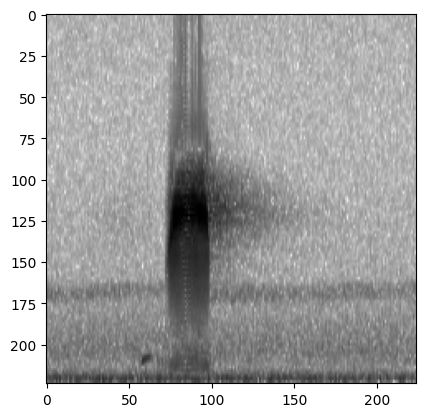

In [6]:
example_file = train_df.loc["/Users/LOF19/Dev/opensoundscape/docs/tutorials/woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav"]
input_tensor, _ = model.preprocessor.forward(example_file, bypass_augmentations=True) # get the tensor as seen by the model
show_tensor(input_tensor)

cam = GradCAM(model=model.network, target_layers=[model.network.layer4[-1]], use_cuda=False)

output_tensor = cam(input_tensor=input_tensor.unsqueeze(0))

In [8]:
samples = pd.read_csv("woodcock_labeled_data/one_hot_labels.csv", index_col=0)
samples.index = "/Users/LOF19/Dev/opensoundscape/docs/tutorials/woodcock_labeled_data/" + samples.index
outputs = model.gradcam(samples)

In [14]:
outputs[0].squeeze().shape

(224, 224)

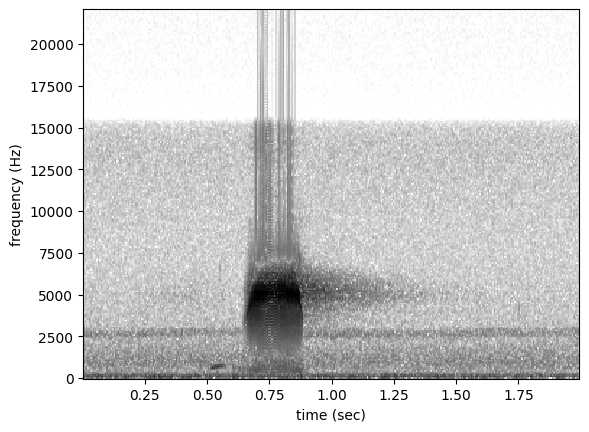

In [20]:

audio = opensoundscape.audio.Audio.from_file("/Users/LOF19/Dev/opensoundscape/docs/tutorials/woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav")
spec = opensoundscape.spectrogram.Spectrogram.from_audio(audio)
spec.plot()

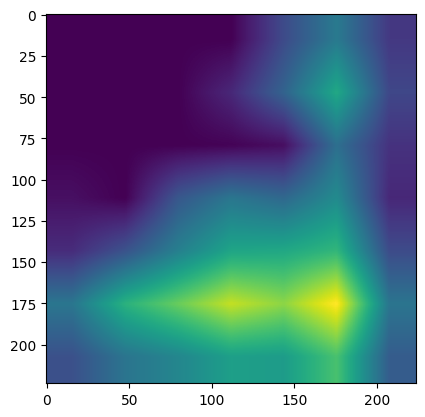

In [12]:
plt.imshow(outputs[0].squeeze())

In [7]:
from opensoundscape.torch.datasets import AudioFileDataset
import torch
prediction_dataset = AudioFileDataset(samples, model.preprocessor)

batch_size = 8
num_workers = 0

dataloader = torch.utils.data.DataLoader(
            prediction_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=False,
            # use pin_memory=True when loading files on CPU and training on GPU
            pin_memory=torch.cuda.is_available(),
        )

In [8]:
for i, batch in enumerate(dataloader):
    batch_tensors = cam(batch["X"])
    break

NameError: name 'final_clip' is not defined

In [16]:
model.network.grad_cam_target_layers = [model.network.layer4[-1]]

In [23]:
model2 = CNN('alexnet', classes=["positive","negative"], sample_duration=2, single_target=True)
model2.network.grad_cam_target_layer

/opt/anaconda3/envs/all_tools_opso_poetry_py38_clone/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [22]:
model3 = CNN('resnet34', classes=["positive","negative"], sample_duration=2, single_target=True)
model3.network.grad_cam_target_layers

/opt/anaconda3/envs/all_tools_opso_poetry_py38_clone/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/all_tools_opso_poetry_py38_clone/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AttributeError: 'ResNet' object has no attribute 'grad_cam_target_layers'

In [27]:
visualization = show_cam_on_image(np.moveaxis(output_tensor, 0, -1), input_tensor, use_rgb=False)

error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/colormap.cpp:736: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'operator()'


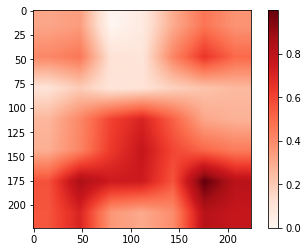

In [14]:
plt.imshow(output_tensor.squeeze(0), cmap='Reds')
plt.colorbar()

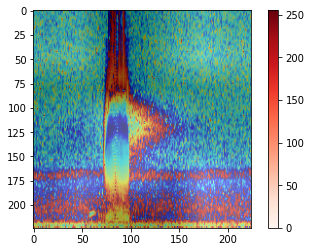

In [17]:
plt.imshow(visualization, cmap = 'Reds')
plt.colorbar()

In [139]:
input_tensor.shape

torch.Size([224, 224, 3])

In [126]:
import cv2
cv2.applyColorMap(np.uint8(input_tensor*255), cv2.COLORMAP_JET)

error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/colormap.cpp:736: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'operator()'


In [125]:
input_tensor.shape

torch.Size([3, 224, 224])

In [128]:
cv2.__version__

'4.6.0'

In [103]:
output_tensor

array([[[0.08821654, 0.08821654, 0.08821654, ..., 0.        ,
         0.        , 0.        ],
        [0.08821654, 0.08821654, 0.08821654, ..., 0.        ,
         0.        , 0.        ],
        [0.08821654, 0.08821654, 0.08821654, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.3895576 , 0.3895576 , 0.3895576 , ..., 0.3006982 ,
         0.3006982 , 0.3006982 ],
        [0.3895576 , 0.3895576 , 0.3895576 , ..., 0.3006982 ,
         0.3006982 , 0.3006982 ],
        [0.3895576 , 0.3895576 , 0.3895576 , ..., 0.3006982 ,
         0.3006982 , 0.3006982 ]]], dtype=float32)

In [104]:
input_tensor

tensor([[[-0.3936, -0.3487, -0.3937,  ..., -0.4031, -0.4063, -0.2449],
         [-0.3928, -0.3658, -0.3919,  ..., -0.4115, -0.4091, -0.2667],
         [-0.3899, -0.4308, -0.3850,  ..., -0.4436, -0.4197, -0.3496],
         ...,
         [ 0.4022,  0.3886,  0.4457,  ...,  0.4299,  0.3676,  0.2829],
         [ 0.2281,  0.2149,  0.3437,  ...,  0.3388, -0.0076,  0.1150],
         [ 0.1823,  0.1691,  0.3168,  ...,  0.3148, -0.1065,  0.0708]],

        [[-0.3936, -0.3487, -0.3937,  ..., -0.4031, -0.4063, -0.2449],
         [-0.3928, -0.3658, -0.3919,  ..., -0.4115, -0.4091, -0.2667],
         [-0.3899, -0.4308, -0.3850,  ..., -0.4436, -0.4197, -0.3496],
         ...,
         [ 0.4022,  0.3886,  0.4457,  ...,  0.4299,  0.3676,  0.2829],
         [ 0.2281,  0.2149,  0.3437,  ...,  0.3388, -0.0076,  0.1150],
         [ 0.1823,  0.1691,  0.3168,  ...,  0.3148, -0.1065,  0.0708]],

        [[-0.3936, -0.3487, -0.3937,  ..., -0.4031, -0.4063, -0.2449],
         [-0.3928, -0.3658, -0.3919,  ..., -0

In [ ]:
### ideal API for grad-cam ###

GradCamObject(model, layer_name, class_index=None, use_cuda=False)


## single gradcam instance 
output_tensor = gradcam(model, input_tensor, layer_name, class_index)

## multiple gradcam instances
model.gradcam = GradCAM(model, layer_name)


output_tensors.save("output_tensor.png")